# Load and minibatch MNIST data
(c) Deniz Yuret, 2018

* Objective: Learning the structure of the MNIST dataset and usage of the Knet.Data struct.
* Prerequisites: [The iteration interface](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-iteration-1)
* Knet: mnistdata, mnistview (used and explained)
* Knet: dir, minibatch (used by mnist.jl)

In [1]:
using Pkg
for p in ("Knet","Images","ImageMagick")
    haskey(Pkg.installed(),p) || Pkg.add(p)
end

In [2]:
# This loads MNIST handwritten digit recognition dataset.
# Traininig and test data go to variables dtrn and dtst
using Knet: Knet, minibatch
include(Knet.dir("data","mnist.jl"))  # defines mnistdata and mnistview
dtrn,dtst = mnistdata(xtype=Array{Float32});

┌ Info: Loading MNIST...
└ @ Main /data/scratch/deniz/.julia/dev/Knet/data/mnist.jl:33


In [3]:
# dtrn contains 600 minibatches of 100 images (total 60000)
# dtst contains 100 minibatches of 100 images (total 10000)
length.((dtrn,dtst))

(600, 100)

In [4]:
# Each minibatch is an (x,y) pair where x is 100 28x28x1 images and y contains their labels.
# Here is the first minibatch in the test set:
(x,y) = first(dtst)
summary.((x,y))

("28×28×1×100 Array{Float32,4}", "100-element Array{UInt8,1}")

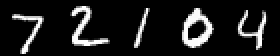

In [5]:
# Here is the first five images from the test set:
using Images, ImageMagick
hcat([mnistview(x,i) for i=1:5]...)

In [6]:
# Here are their labels (0x0a=10 is used to represent 0)
@show y[1:5];

y[1:5] = UInt8[0x07, 0x02, 0x01, 0x0a, 0x04]


In [7]:
# dtrn and dtst are implemented as Julia iterators (see https://docs.julialang.org/en/v1/manual/interfaces)
# This means they can be used in for loops, i.e. `for (x,y) in dtst`
cnt = zeros(Int,10)
for (x,y) in dtst
    for label in y
        cnt[label] += 1
    end
end
@show cnt;

cnt = [1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009, 980]
